# Time series analysis part 2

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import product
from tqdm import tqdm_notebook

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [2]:
ads = pd.read_csv('datasets/ads.csv', index_col=['Time'], parse_dates=['Time'])
currency = pd.read_csv('datasets/currency.csv', index_col=['Time'], parse_dates=['Time'])

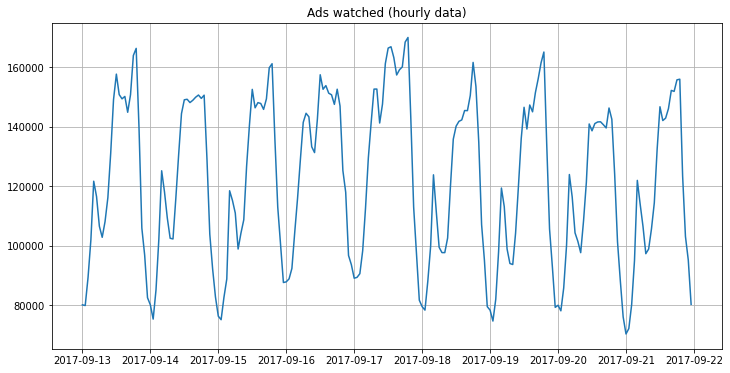

In [3]:
plt.figure(figsize=(12, 6))
plt.plot(ads.Ads)
plt.title('Ads watched (hourly data)')
plt.grid(True)
plt.show()

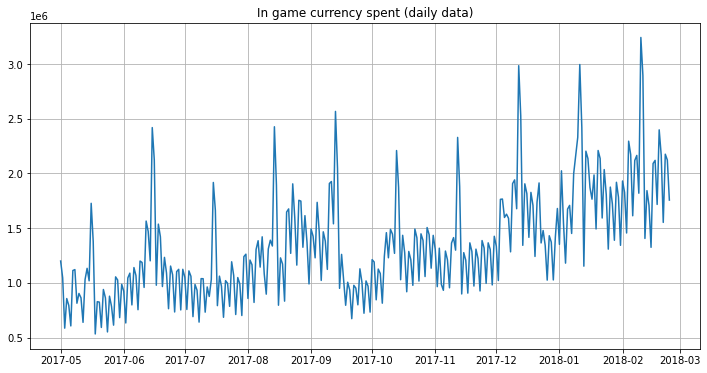

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(currency.GEMS_GEMS_SPENT)
plt.title('In game currency spent (daily data)')
plt.grid(True)
plt.show()

In [5]:
# creating copy of initial datagrame to make various transformations
data = pd.DataFrame(ads.Ads.copy())
data.columns = ['y']

In [6]:
# Adding the lag of the target variable from 6 steps back up to 24
for i in range(6, 25):
    data[f'lag_{i}'] = data.y.shift(i)

In [7]:
# take a look at the new dataframe
data.tail(7)

,y,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
Time,,,,,,,,,,,,,,,,,,,,
2017-09-21 17:00:00,151790,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0,123945.0,142425.0,146215.0,139515.0
2017-09-21 18:00:00,155665,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0,123945.0,142425.0,146215.0
2017-09-21 19:00:00,155890,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0,123945.0,142425.0
2017-09-21 20:00:00,123395,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0,123945.0
2017-09-21 21:00:00,103080,146020.0,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0
2017-09-21 22:00:00,95155,152120.0,146020.0,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0
2017-09-21 23:00:00,80285,151790.0,152120.0,146020.0,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0


In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

# for time-series cross-validation set 5 folds
tscv = TimeSeriesSplit(n_splits=5)

In [9]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to the timeseries sctructure
    """
    
    # get the index after which test set stats
    test_index = int(len(X)*(1 - test_size))
    
    X_train = X.iloc[:test_index -1]
    y_train = y.iloc[:test_index -1]
    X_test = X.iloc[:test_index]
    y_test = y.iloc[:test_index]
    
    return X_train, X_test, y_train, y_test

In [10]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=.3)

In [11]:
# machine learning in two lines
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [12]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);

    
def plot_coefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ['coef']
    coefs['abs'] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by='abs', ascending=False).drop(['abs'], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');
def plot_coefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ['coef']
    coefs['abs'] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by='abs', ascending=False).drop(['abs'], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

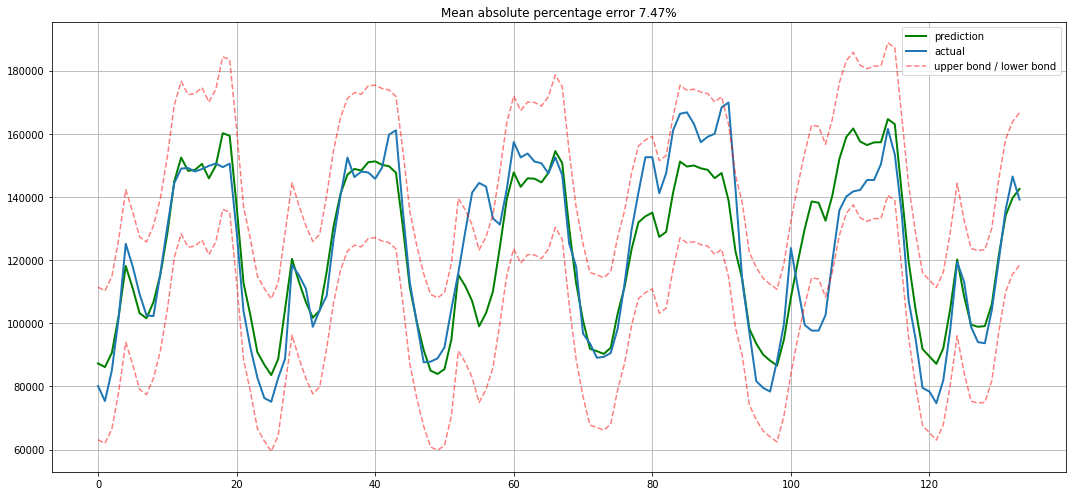

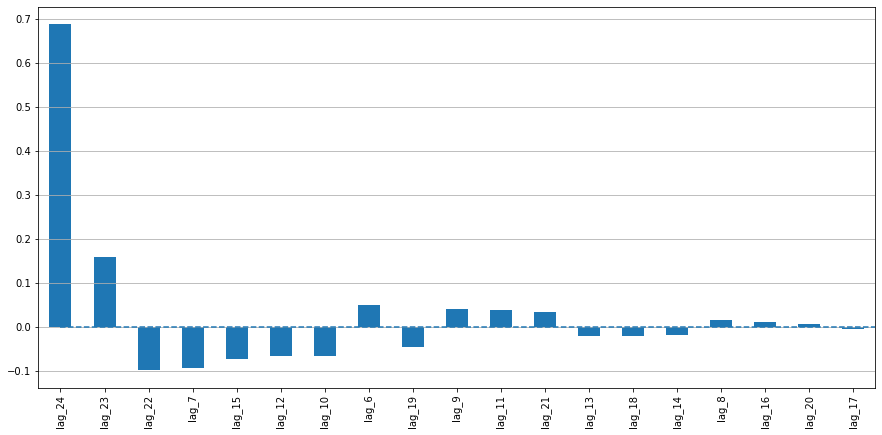

In [13]:
plotModelResults(lr, plot_intervals=True)
plot_coefficients(lr)

Добавим в датасет час, день недели и выходной в качестве категориальных переменных. Для этог переводим имеющийся в
датафрейме индекс в формат datetime и извлекаем из него hour и weekday.

In [14]:
data.index = pd.to_datetime(data.index)
data['hour'] = data.index.hour
data['weekday'] = data.index.weekday
data['is_weekend'] = data.weekday.isin([5, 6])*1
data.tail()

,y,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,...,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,hour,weekday,is_weekend
Time,,,,,,,,,,,,,,,,,,,,,
2017-09-21 19:00:00,155890,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,...,72150.0,70335.0,76050.0,88170.0,101360.0,123945.0,142425.0,19,3,0
2017-09-21 20:00:00,123395,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,...,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0,123945.0,20,3,0
2017-09-21 21:00:00,103080,146020.0,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,...,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0,21,3,0
2017-09-21 22:00:00,95155,152120.0,146020.0,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,...,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,22,3,0
2017-09-21 23:00:00,80285,151790.0,152120.0,146020.0,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,...,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,23,3,0


Можно визуализировать получившиеся признаки

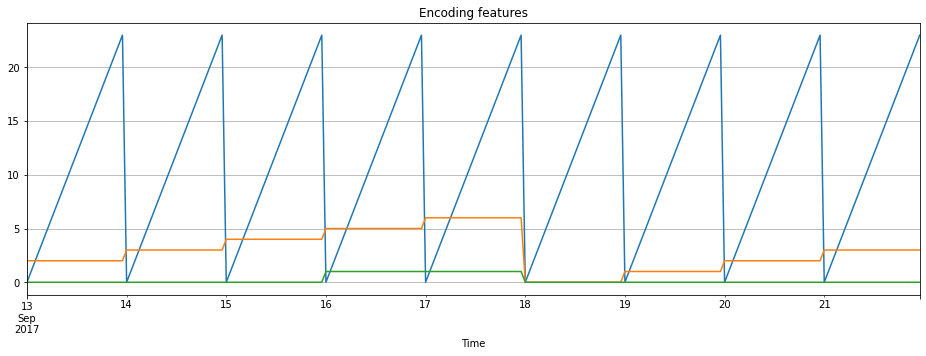

In [15]:
plt.figure(figsize=(16, 5))
plt.title('Encoding features')
data.hour.plot()
data.weekday.plot()
data.is_weekend.plot()
plt.grid(True)

Так как теперь у нас данные в разном масштабе - десятки тысяч в лагах и единицы в категориях, имеет смысл привести всё
к одному масштабу, чтобы можно было по-прежнему исследовать коэффициенты модели. Для этоговоспользуемся *StandardScaler*

In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

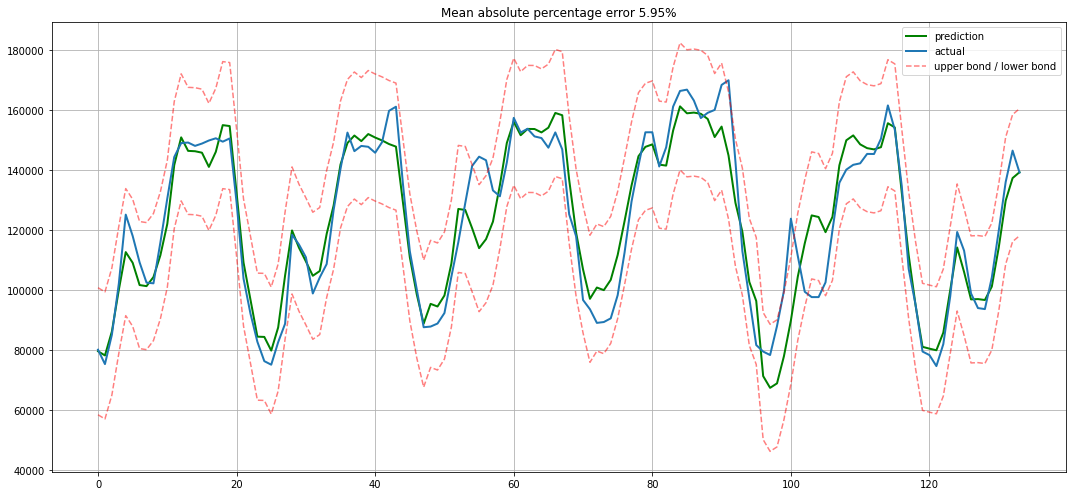

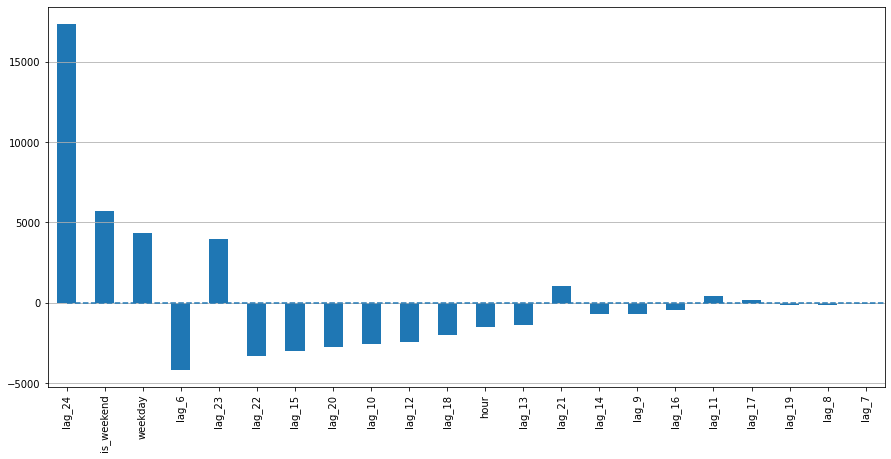

In [17]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=.3)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True)
plot_coefficients(lr)

Ошибка на тесте еще немного уменьшилась и по коэффициентам видно, что день недели выходной - довольн неплохие признаки

# Кодирование средним (target encoding)

Иногда в качестве признака добавлять среднее значение переменной. В нашем случае каждый день недели или час дня 
можно закодировать соответствующим средним числом просмотров рекламы/траты игровой валюты, пришедшиеся на этот день недели
или этот час. При этом важно следить за тем, чтобы расчет среднего значения производился только в рамках тренировочного 
датасета (или в рамках текущего наблюдаемого фолда при кроссвалидации), иначе можно ненароком привнести в модель 
информацию о будущем.

In [18]:
def code_mean(data, cat_feature, real_feature):
    """
    Returns a dictonary where keys are unique categories of the cat_feature,
    and values are means over real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

Посмотрим на средние по часам

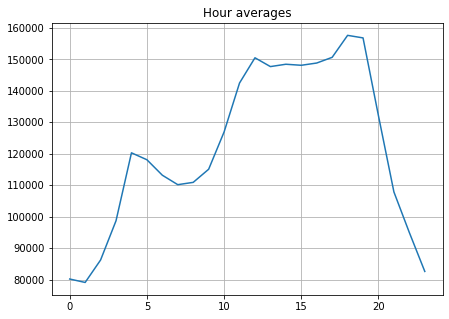

In [19]:
average_hour = code_mean(data, 'hour', 'y')
plt.figure(figsize=(7, 5))
plt.title('Hour averages')
pd.DataFrame.from_dict(average_hour, orient='index')[0].plot()
plt.grid(True);

А теперь объединим кодирование признаков одной функцией и добавим к признакам кодирование средним

In [20]:
def prepareData(series, lag_start, lag_end, test_size, target_encoding=False, get_dummies=False):
    """
        series: pd.DataFrame
            dataframe with timeseries

        lag_start: int
            initial step back in time to slice target variable 
            example - lag_start = 1 means that the model 
                      will see yesterday's values to predict today

        lag_end: int
            final step back in time to slice target variable
            example - lag_end = 4 means that the model 
                      will see up to 4 days back in time to predict today

        test_size: float
            size of the test dataset after train/test split as percentage of dataset

        target_encoding: boolean
            if True - add target averages to the dataset
            
        get_dummies: boolean
            if True - encode categorical into dummies
        
    """
        
    # copy of initial dataset
    data = pd.DataFrame(series.copy())
    data.columns = ['y']
    
    # lags of series
    for i in range(lag_start, lag_end):
        data[f'lag_{i}'] = data.y.shift(i)
    
    # datetime features
    data.index = pd.to_datetime(data.index)
    data['hour'] = data.index.hour
    data['weekday'] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5, 6]) * 1
    
    if target_encoding:
        # calculate averages on train set only
        test_index = int(len(data.dropna()) * (1 - test_size))
        data['weekday_average'] = list(map(code_mean(data[:test_index], 'weekday', 'y').get, data.weekday))
        data['hour_average'] = list(map(code_mean(data[:test_index], 'hour', 'y').get, data.hour))
        
        # drop encoded variables
        data.drop(['hour', 'weekday'], axis=1, inplace=True)
        
    if get_dummies:
        data = pd.get_dummies(data, columns=['hour', 'weekday'])
        
    # train test split
    y = data.dropna().y
    X = data.dropna().drop(['y'], axis=1)
    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=test_size)
    
    return X_train, X_test, y_train, y_test

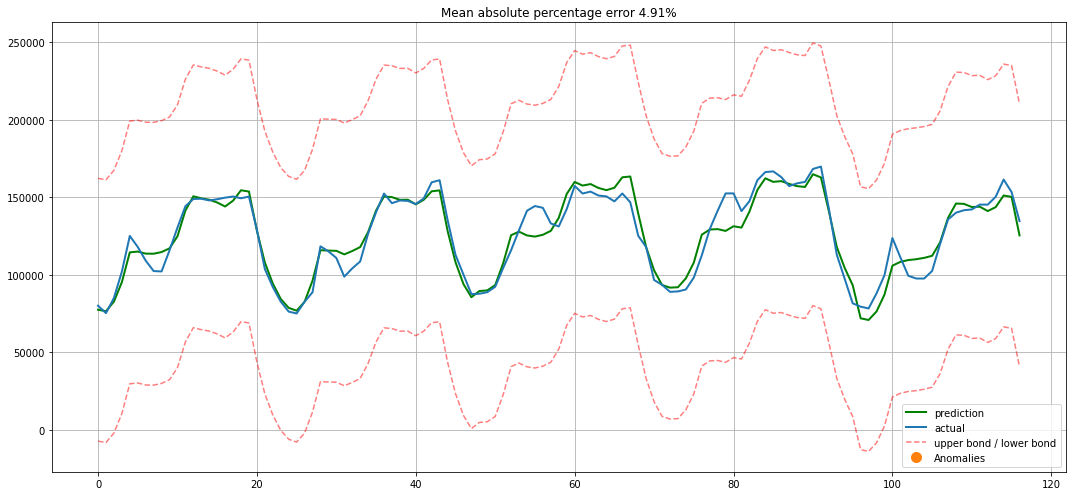

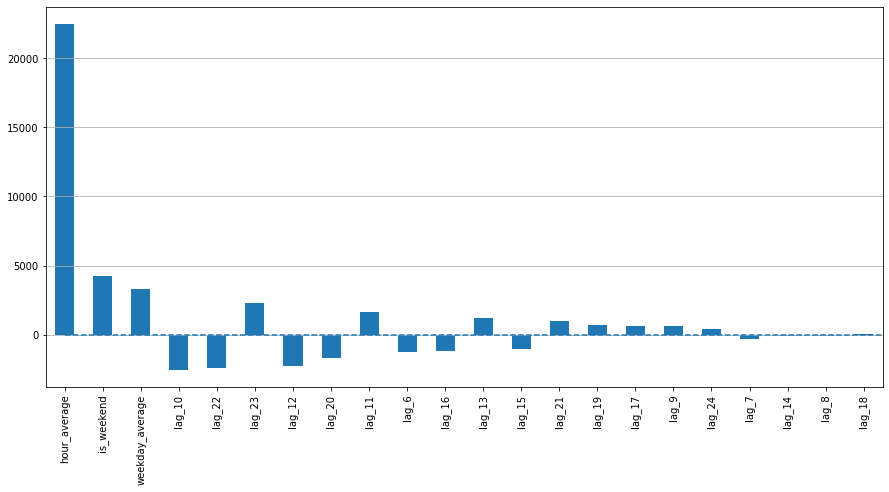

In [21]:
X_train, X_test, y_train, y_test = prepareData(ads.Ads, lag_start=6, lag_end=25, test_size=.3, target_encoding=True)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True, plot_anomalies=True)
plot_coefficients(lr)

In [22]:
X_train, X_test, y_train, y_test = prepareData(ads.Ads, lag_start=6, lag_end=25, test_size=.3, target_encoding=False, get_dummies=True)

column_to_scale = [col for col in X_train.columns if 'lag' in col]
X_train_scaled = scaler.fit_transform(X_train[column_to_scale])
X_test_scaled = scaler.transform(X_test[column_to_scale])

X_train[column_to_scale] = X_train_scaled
X_test[column_to_scale] = X_test_scaled

In [23]:
X_train.head()

,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,...,hour_21,hour_22,hour_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
Time,,,,,,,,,,,,,,,,,,,,,
2017-09-14 00:00:00,1.462254,0.974267,0.751933,0.931678,0.889327,0.926818,1.160528,0.837541,0.166984,-0.392067,...,0,0,0,0,0,0,1,0,0,0
2017-09-14 01:00:00,1.548454,1.447228,0.964154,0.741253,0.918151,0.875691,0.911138,1.151101,0.832507,0.161860,...,0,0,0,0,0,0,1,0,0,0
2017-09-14 02:00:00,0.586940,1.533367,1.436354,0.952796,0.727666,0.904675,0.859628,0.899558,1.149545,0.830436,...,0,0,0,0,0,0,1,0,0,0
2017-09-14 03:00:00,-0.623276,0.572521,1.522356,1.423488,0.939276,0.713126,0.888829,0.847603,0.895211,1.148930,...,0,0,0,0,0,0,1,0,0,0
2017-09-14 04:00:00,-0.951339,-0.636854,0.563053,1.509215,1.410117,0.925918,0.695847,0.877057,0.842680,0.893429,...,0,0,0,0,0,0,1,0,0,0


Для начала убедимся, что нам есть, что отбрасывать и в данных действительно очень моного скореллированных признаков

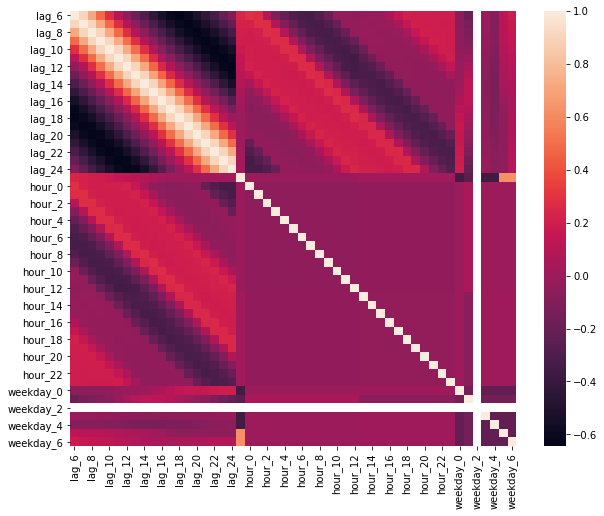

In [24]:
plt.figure(figsize=(10, 8))
sns.heatmap(X_train.corr());

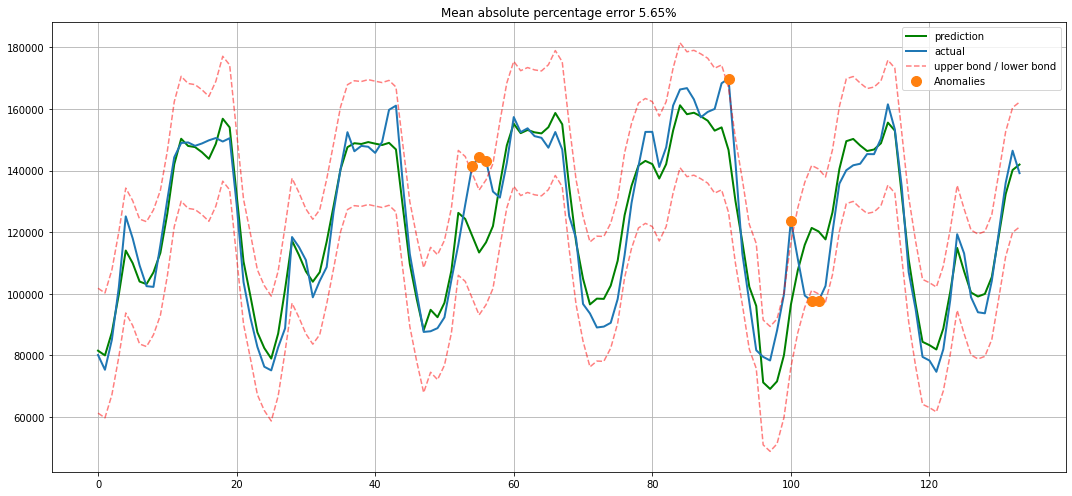

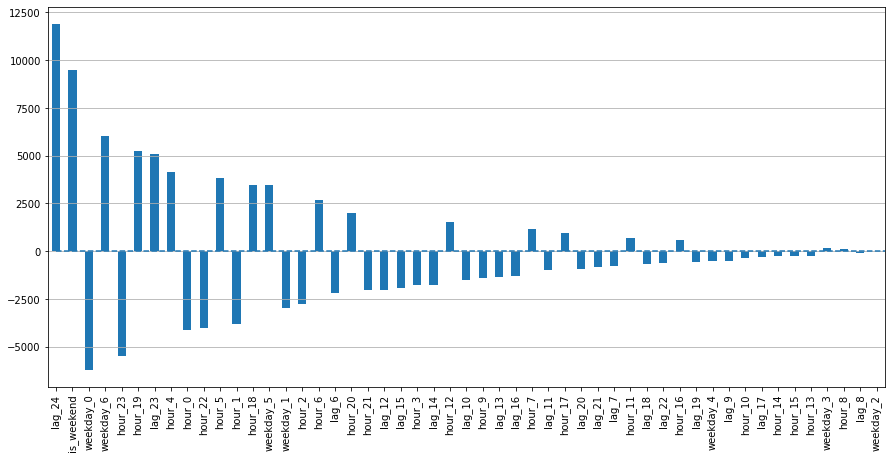

In [25]:
from sklearn.linear_model import LassoCV, RidgeCV

ridge = RidgeCV(cv=tscv, alphas=np.linspace(5, 10))
ridge.fit(X_train, y_train)

plotModelResults(ridge,
                 X_train=X_train,
                 X_test=X_test,
                 plot_intervals=True, plot_anomalies=True)
plot_coefficients(ridge)

Хорошо видно, как всё ближе и ближе прижимаются к нулю (хотя никогда нулю не равны) коэффициенты в моделе по мере убывания их важности.

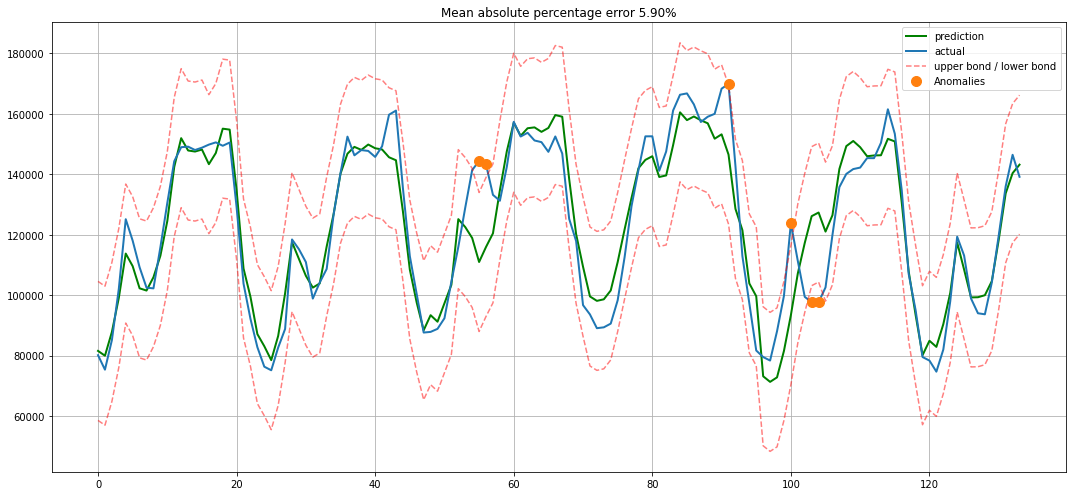

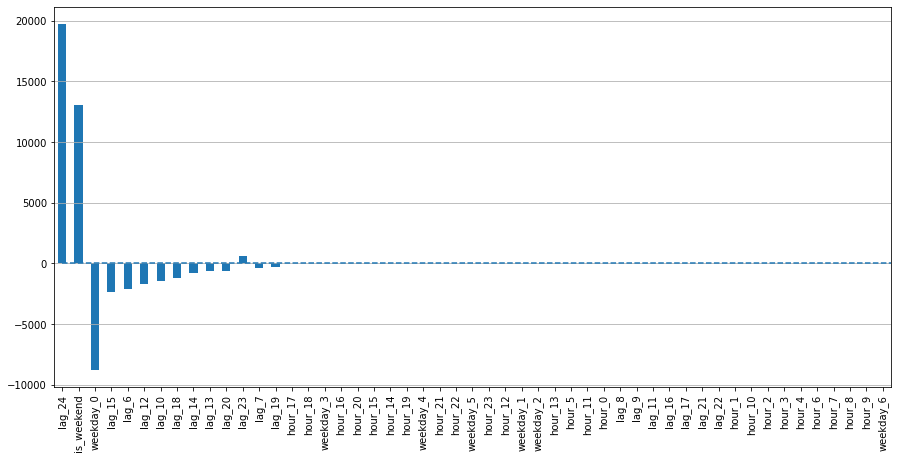

In [26]:
lasso = LassoCV(cv=tscv, eps=.01)
lasso.fit(X_train, y_train)

plotModelResults(lasso,
                 X_train=X_train,
                 X_test=X_test,
                 plot_intervals=True, plot_anomalies=True)
plot_coefficients(lasso)

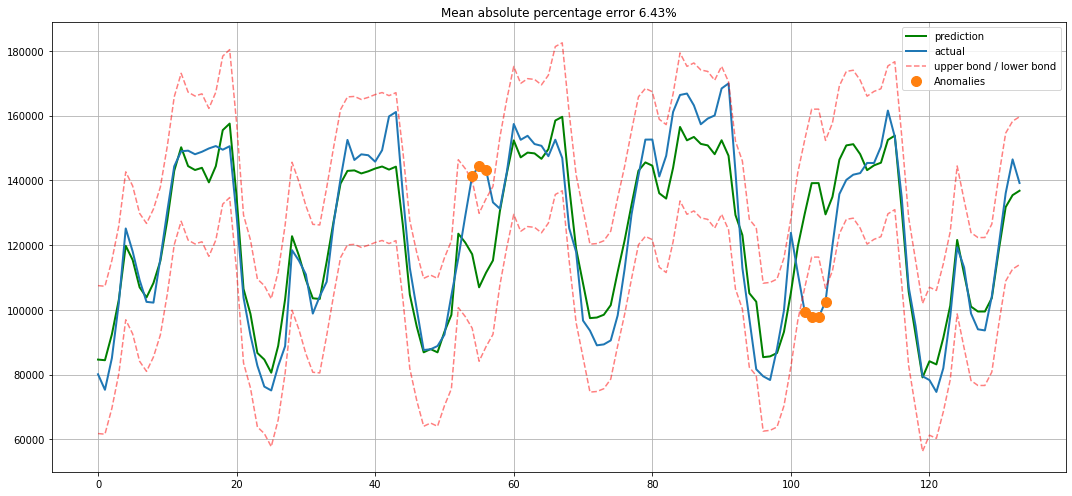

In [27]:
lasso = LassoCV(cv=tscv, eps=.01)
lasso.fit(X_train[['lag_24', 'is_weekend', 'weekday_0']], y_train)

plotModelResults(lasso,
                 X_train=X_train[['lag_24', 'is_weekend', 'weekday_0']],
                 X_test=X_test[['lag_24', 'is_weekend', 'weekday_0']],
                 plot_intervals=True, plot_anomalies=True)
# plot_coefficients(lasso)

# Boosting

Почему бы теперь не попробовать бустинг?

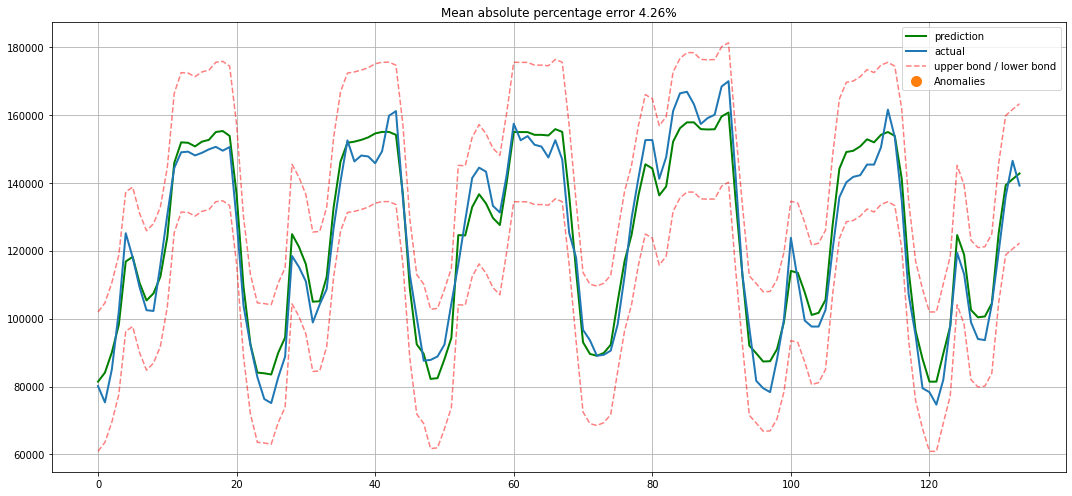

In [28]:
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor

gbr = AdaBoostRegressor(n_estimators=100)
gbr.fit(X_train_scaled, y_train)

plotModelResults(gbr,
                  X_train=X_train_scaled,
                  X_test=X_test_scaled,
                  plot_intervals=True, plot_anomalies=True)

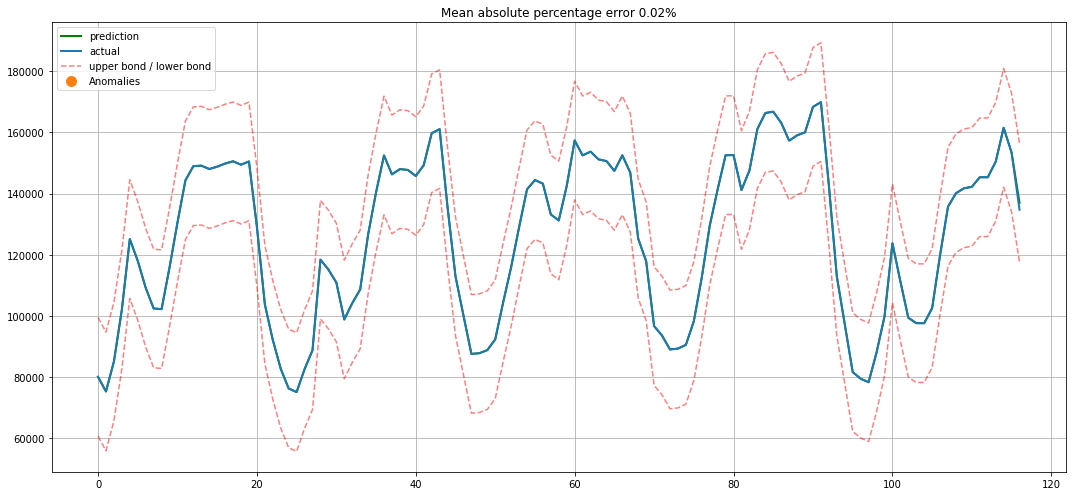

In [29]:
from catboost import CatBoostRegressor

X_train, X_test, y_train, y_test = \
prepareData(ads.Ads, lag_start=6, lag_end=25, test_size=.3, target_encoding=True)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

catboost = CatBoostRegressor(iterations=100, learning_rate=.7,
                            loss_function='RMSE', verbose=0)

catboost.fit(X_train_scaled, y_train, verbose=0)

plotModelResults(catboost,
                X_train=X_train_scaled,
                X_test=X_test_scaled,
                plot_intervals=True, plot_anomalies=True)

Не стоит первым делом при работе с временным рядом расчехлять xgboost. Дело в том, что модели с деревьями внутри,
в отличие от линейных, довольно плохо справляются с трендами без помощи трюков с обработкой данных. 
В идеале - предварительно очистить данные от тренда, спрогнозировать тренд отдельно при помощи линейной модели, и
отдельно очищенный ряд, а потом сложить вместе предсказания.

# To Infinity and Beyond

## Facebook Prophet - automatic routines

## Facebook Prophet - automating routines

![](https://miro.medium.com/max/1060/0*tVCene42rgUTNv9Q.png)

https://github.com/facebook/prophet

[Предсказываем будущее с помощью библиотеки Facebook Prophet](https://habrahabr.ru/company/ods/blog/323730/)

Библиотека prophet позволяет быстро и достаточно качественно автоматически строить прогнозы временныз рядов. Подробно про теорию работы можно почитать в замечательной статьей по ссылке выше, а сейчас посмотрим на практике, как она работает

In [30]:
from fbprophet import Prophet

ModuleNotFoundError: No module named 'fbprophet'

In [ ]:
# number of future predictions
predictions = 60

# creating a specific format dataset 
df = ads.reset_index()
df.columns = ['ds', 'y']
df.tail()

In [ ]:
# reserve some data for testing
train_df = df[:-predictions]

In [ ]:
# declaring the model, it's necessary to pay attention to seasonality type we want to use
model = Prophet(weekly_seasonality=True, yearly_seasonality=False)
model.fit(train_df)

# creating one more specific dataset for predictions
# we also need to set data frequency here (by default - days)
future = model.make_future_dataframe(periods=predictions, freq='H')
future.tail()

In [ ]:
# finally, making predictions
forecast = model.predict(future)
forecast.tail()

In [ ]:
# pictures!
error = mean_absolute_percentage_error

In [ ]:
# pictures!
error = mean_absolute_percentage_error(df[-predictions:]['y'], forecast[-predictions:]['yhat'])
print("Mean absolute percentage error {0:.2f}%".format(error))
_ = model.plot(forecast)

In [ ]:
_ = model.plot_components(forecast)

# Amazon GluonTS - new big player on the market 

https://github.com/awslabs/gluon-ts

В июне 2019 года компания Amazon выложила в открытый доступ замечательный инструмент - [GluonTS](https://github.com/awslabs/gluon-ts), позволяющий максимально быстро и эффективно строить, оценивать и использовать модели временных рядов, основанные на глубоком обучении и вероятностном подходе. 

## Что внутри GluonTS?

Amazon пошёл дальше и использовал рекуррентные нейронные сети (в частности, LSTM), а также свертки и механизмы внимания, обернув всё это в крайне удобную верхнеуровневую библиотеку. В частности, GluonTS содержит:
- Инструменты, необходимые для построения и обучения наиболее распространённых архитектур нейронных сетей, а также компоненты для моделирования и трансформации вероятностых распределений
- Механизмы для загрузки и предварительной обработки данных, в том числе автоматической генерации признаков из временных рядов
- Несколько готовых к использованию state-of-the-art прогнозных моделей
- Инструменты для оценки и сравнения различных моделей

Если не вдаваться в подробности, GluonTS позволяет быстро и практически из коробки получить качественную модель временного ряда, на выходе из которой вместо точечной оценки прогнозных значений мы получаем целое смоделированное вероятностное распределение. Таким образом, мы можем с лёгкостью оперировать доверительными интервалами прогноза и с любой удобной нам вероятностью получать диапазон наиболее вероятных будущих значений ряда. 


В [оригинальной статье](https://aws.amazon.com/ru/blogs/machine-learning/creating-neural-time-series-models-with-gluon-time-series/) авторы использовали временной ряд с ценами акций компании Amazon. Ярко выраженных паттернов, за исключением восходящих/нисходящих трендов, в финансовых временных рядах обычно не бывает, поэтому прогнозы в статье выглядят больше как некоторый шум, колеблющийся вокруг спрогнозированной линии тренда.

Так что посмотрим, чего можно добиться на наших собственных данных

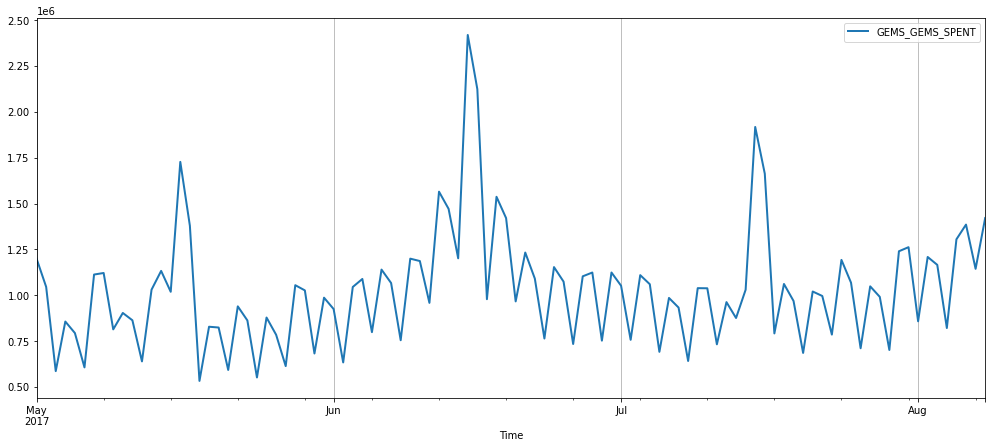

In [31]:
df = pd.read_csv('datasets/currency.csv', index_col=0)
df.index = pd.to_datetime(df.index)

df[:100].plot(linewidth=2, figsize=(17, 7))
plt.grid(axis='x')
plt.show()

## Готовим данные

Пробуем построить модель. GluonTS представляет верхнеуровневую абстракцию *Dataset*, которая переводит разнородные форматы
данных в один, удобный для последующей работы моделей. В часности, *ListDataset* переводит данные в списов словарей, где
отдельно записаны значения ряда и таймстампы. Для создания такого датасета мы передаем наш исходный временной ряд, указываем
его частоту (в данном случае у нас дневные данные, поэтому частота "D"), а так же точку, до которой наш ряд будет отнесен
к тренировочной выборке.

In [32]:
df.index[0]

Timestamp('2017-05-01 00:00:00')

In [33]:
from gluonts.dataset.common import ListDataset
training_data = ListDataset(
    [{'start': df.index[0], 'target': df.GEMS_GEMS_SPENT[:'2017-08-01']}],
    freq = 'D'
)

Посмотрим, в какой формат преобразовались данные

In [34]:
training_data.list_data

[{'start': Timestamp('2017-05-01 00:00:00'),
  'target': Time
  2017-05-01    1199436
  2017-05-02    1045515
  2017-05-03     586111
  2017-05-04     856601
  2017-05-05     793775
                 ...   
  2017-07-28     991163
  2017-07-29     701672
  2017-07-30    1239717
  2017-07-31    1261953
  2017-08-01     857930
  Name: GEMS_GEMS_SPENT, Length: 93, dtype: int64}]

# Обучаем модель

In [35]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
from gluonts.dataset.util import to_pandas

# Time Series FeatuRe Extraction based on Scalable Hypothesis tests

## А вы и признаки за меня придумывать будете? 

<img src="https://tsfresh.readthedocs.io/en/latest/_images/introduction_ts_exa_features.png" width=500>


Основная идея библиотеки tsfresh - сгенерировать как можно больше признаков (если позволяют вычислительные ресурсы), а затем при помощи моделей или статистических критериев из этих признаков уже можно отобрать только те, которые релевантны для текущей задачи. Признаки могут быть как достаточно привычные - те же средние, максимальные и минимальные значения, так и довольно экзотичные, например, p-value коэффициента наклона линии тренда в текущем скользящем окне. Безусловно, не все эти признаки окажутся полезными (некоторые и вовсе могут оказаться константными), поэтому библиотека предоставляет небольшой инструментарий, который позволит быстро убрать самый откровенный мусор. 

Давайте разберём всё на интересном примере - распознавание активности человека по данным акселерометра с мобильного телефона: 

In [36]:
# импортируем необходимые функции из бииблиотеки
from tsfresh.examples.har_dataset import download_har_dataset, load_har_dataset, load_har_classes
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import settings

In [37]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

Загрузим данные, которые удобно находятся в самой билиотеке. Суммарно у нас есть 7352 наблюдений, каждому из которых
соответствует 128 показаний акселерометра и одна из шести возможных активностей (подробное описание датасета можно найти [здесь](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones)))

In [38]:
download_har_dataset()
data = load_har_dataset()
y = load_har_classes()
print(data.shape)
data.head()

(7352, 128)


,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,0.000181,0.010139,0.009276,0.005066,0.010810,0.004045,0.004757,0.006214,0.003307,0.007572,...,0.001412,-0.001509,0.000060,0.000435,-0.000819,0.000228,-0.000300,-0.001147,-0.000222,0.001576
1,0.001094,0.004550,0.002879,0.002247,0.003305,0.002416,0.001619,0.000981,0.000009,-0.000363,...,-0.000104,-0.000141,0.001333,0.001541,0.001077,-0.000736,-0.003767,-0.004646,-0.002941,-0.001599
2,0.003531,0.002285,-0.000420,-0.003738,-0.006706,-0.003148,0.000733,0.000668,0.002162,-0.000946,...,0.000661,0.001853,-0.000268,-0.000394,-0.000279,-0.000316,0.000144,0.001246,0.003117,0.002178
3,-0.001772,-0.001311,0.000388,0.000408,-0.000355,0.000998,0.001109,-0.003149,-0.008882,-0.010483,...,0.000458,0.002103,0.001358,0.000820,-0.000212,-0.001915,-0.001631,-0.000867,-0.001172,-0.000028
4,0.000087,-0.000272,0.001022,0.003126,0.002284,0.000885,0.001933,0.002270,0.002247,0.002175,...,0.002529,0.003518,-0.000248,-0.002761,0.000252,0.003752,0.001626,-0.000698,-0.001223,-0.003328


In [39]:
y.shape

(7352,)

In [40]:
y.value_counts()

6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: 0, dtype: int64

<AxesSubplot:>

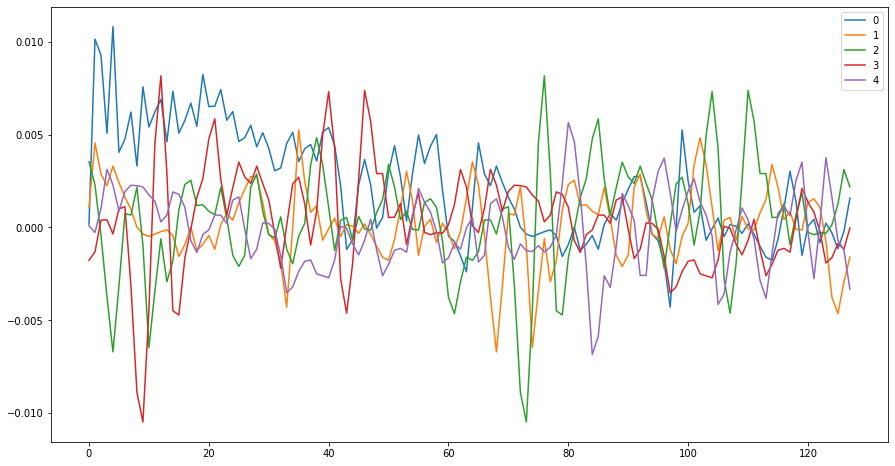

In [41]:
data.head().T.plot(figsize=(15, 8))

Для начала давайте обучим простую модель на сырых данных, т.е. возьмем все 128 наблюдений акселерометра и засунем их в
качестве признаков в случайный лес с дефолтными значениями.

In [42]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=.2)
cl = DecisionTreeClassifier()
cl.fit(X_train, y_train)
print(classification_report(y_test, cl.predict(X_test)))

              precision    recall  f1-score   support

           1       0.65      0.67      0.66       238
           2       0.56      0.60      0.58       204
           3       0.70      0.60      0.65       181
           4       0.31      0.33      0.32       268
           5       0.37      0.39      0.38       278
           6       0.48      0.44      0.46       302

    accuracy                           0.49      1471
   macro avg       0.51      0.51      0.51      1471
weighted avg       0.50      0.49      0.49      1471



В результате получили бейзлайн оценки качества для нашей многоклассовой классификации. Хорошо видно, что некоторые классы
модель распознает с большей точностью, чем другие (обычно на этом датасете сложнее всего отличить сидячих людей от стоячих).
Баз бейзлайн на сырых признаках есть - настало время извлечь что-то поинтереснее!

В tsfresh есть различные предустановленные варианты извлечения признаков, которыми можно воспользоваться из коробки и особо не думать насчет содержания. Отлиаются они лишь количеством рассчитываемых признаков, а значит, скоростью обработки данных
и количеством информации, которую эти признаки смогут передать. При желании, можно так же вручную изменять набор рассчитываемых признаков.

Первый и самый базовый набор признаков дает `MinimalFCParameters`. Используя такую настройку мы получим джентльменский набор признаков для каждого наблюдения, а именно: сумму, медиану, среднее, длину, стандартное отклонение, дисперсию, максимальное и минимальное значение каждого ряда.

Обычно такие признаки не дают хорошего качества (всё-таки их не так много и они представляют собой лишь базовые статистики,
описывающие распределение значений). Однако такой набор удобно использовать для прототипирования, построения бейзлайнов или
в случае, когда получениедругих признаков занимает слишком много времени.

In [43]:
settings_minimal = settings.MinimalFCParameters()
settings_minimal

{'sum_values': None,
 'median': None,
 'mean': None,
 'length': None,
 'standard_deviation': None,
 'variance': None,
 'root_mean_square': None,
 'maximum': None,
 'minimum': None}

Теперь посмотрим, как можно скомбинировать несколько разных вариантов извлечения признаков. Добавим к текущему минимальному 
ещё один - `TimeBasedFCParameters`. Этот метод посчитает по нашему ряду линейный тренд, возьмет оттуда значение коэффициента
R2, intercept, slope, стандартную ошибку и p-value, и всё это сделает новыми признаками для объекта. При помощи простого
совмещения двух словарей с правилами мы получаем уже чуть более интересный набор признаков, который по-прежнему будет достаточно быстро считаться даже на больших датасетах.

In [44]:
settings.TimeBasedFCParameters()

{'linear_trend_timewise': [{'attr': 'pvalue'},
  {'attr': 'rvalue'},
  {'attr': 'intercept'},
  {'attr': 'slope'},
  {'attr': 'stderr'}]}

In [45]:
settings_time = settings.TimeBasedFCParameters()
settings_time.update(settings_minimal)
settings_time

{'linear_trend_timewise': [{'attr': 'pvalue'},
  {'attr': 'rvalue'},
  {'attr': 'intercept'},
  {'attr': 'slope'},
  {'attr': 'stderr'}],
 'sum_values': None,
 'median': None,
 'mean': None,
 'length': None,
 'standard_deviation': None,
 'variance': None,
 'root_mean_square': None,
 'maximum': None,
 'minimum': None}

Следующий набор - `EfficientFCParameters`. Здесь число различных признаков уже заметно выше, чем в предыдущих вариантах.
Рассчитаваются коэффициенты skewness и kurtoses, считается, сколько раз повторялось значение минимума и максимума, различные
квантили, оконные статистики, автокорреляции и многое-многое другое, `Efficient` это набор потому, что он по-прежнему
относительно быстро считается и не требует значительных вычислительных затрат на построение признакового пространства.

In [46]:
settings_efficient = settings.EfficientFCParameters()
settings_efficient

{'variance_larger_than_standard_deviation': None,
 'has_duplicate_max': None,
 'has_duplicate_min': None,
 'has_duplicate': None,
 'sum_values': None,
 'abs_energy': None,
 'mean_abs_change': None,
 'mean_change': None,
 'mean_second_derivative_central': None,
 'median': None,
 'mean': None,
 'length': None,
 'standard_deviation': None,
 'variation_coefficient': None,
 'variance': None,
 'skewness': None,
 'kurtosis': None,
 'root_mean_square': None,
 'absolute_sum_of_changes': None,
 'longest_strike_below_mean': None,
 'longest_strike_above_mean': None,
 'count_above_mean': None,
 'count_below_mean': None,
 'last_location_of_maximum': None,
 'first_location_of_maximum': None,
 'last_location_of_minimum': None,
 'first_location_of_minimum': None,
 'percentage_of_reoccurring_values_to_all_values': None,
 'percentage_of_reoccurring_datapoints_to_all_datapoints': None,
 'sum_of_reoccurring_values': None,
 'sum_of_reoccurring_data_points': None,
 'ratio_value_number_to_time_series_length':

Наконец-то самый большой и полный вариант - `ComprehensiveFCParameters`, в которомдобавляются неэффективные в вычислительном плане признаки, но вполне возможно, что они дадут дополнительный прирост в качестве при обучении моделей.

In [47]:
settings_comprehensive = settings.ComprehensiveFCParameters()
len(settings_comprehensive)

74

Для текущего туториалы давайте возьмем эффективный список параметров и построим с его помощью наше новое признаковое пространство. 
Для начала нужно преобразовать датасет в `long` формат, неогбходимый для работы библиотеки. В этом формате у нас будет всего
два столбца: в первом будут храниться все наблюдения акселерометров, во втором - соответствующий интекс наблюдения.

In [48]:
data_long = pd.DataFrame({0: data.values.flatten(), 
                          1: np.arange(data.shape[0]).repeat(data.shape[1])})
print(data_long.shape)
data_long.head()

(941056, 2)


,0,1
0,0.000181,0
1,0.010139,0
2,0.009276,0
3,0.005066,0
4,0.010810,0


In [52]:
data_long.head(129)

,0,1
0,0.000181,0
1,0.010139,0
2,0.009276,0
3,0.005066,0
4,0.010810,0
...,...,...
124,-0.000300,0
125,-0.001147,0
126,-0.000222,0
127,0.001576,0


В результате наш датасет удлинился практически до миллиона строк.

Извлекаем признаки при помощи extract_features, указав в качестве параметров для извлечения наш эффективный список. Также
укажем параметр для `impute_function`, передав туда функцию `impute`, импортированную выше из `tsfresh.utilites.dataframe_functions`. Эта функцияавтоматически заполнит все пропуски в получившемся датасете (если они там внезапно появятся)

In [54]:
X = extract_features(
    data_long, column_id=1,
    impute_function=impute,
    default_fc_parameters=settings_efficient,
    n_jobs=12
)
print(X.shape)

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 60/60 [02:01<00:00,  2.03s/it]


(7352, 781)


Спустя 5 минут работы бибилиотеки, получаем готовый датасет, где каждому наблюдению соответствуетуже не 128 сырых значений акселерометра, а 781 извлеченный признаков.
Попробуем теперь обучить модель на них.

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
cl = DecisionTreeClassifier()
cl.fit(X_train, y_train)
print(classification_report(y_test, cl.predict(X_test)))

              precision    recall  f1-score   support

           1       0.91      0.94      0.93       233
           2       0.85      0.87      0.86       206
           3       0.95      0.89      0.92       216
           4       0.42      0.44      0.43       259
           5       0.46      0.48      0.47       265
           6       0.64      0.60      0.62       292

    accuracy                           0.68      1471
   macro avg       0.71      0.70      0.70      1471
weighted avg       0.69      0.68      0.69      1471

